# Oscilloskope USBTCM utility

In [2]:
import matplotlib.pyplot as plt
import sys
import os
import time
import h5py
import numpy as np


# TRYING TO ADAPT THE SCRIPT FOR THE MICSIG detector

# Create ownership rule as /etc/udev/rules.d/99-micsig.rules
# SUBSYSTEMS=="usb", ATTRS{idVendor}=="18d1", ATTRS{idProduct}=="0303", GROUP="medved", MODE="0666"

class UsbTmcDriver:

    def __init__(self, device):
        self.device = device
        self.FILE = os.open(device, os.O_RDWR)
 
    def write(self, command):
        os.write(self.FILE, command);
 
    def read(self, length = 2048):
        return os.read(self.FILE, length)
 
    def getName(self):
        self.write("*IDN?")
        return self.read(300)
 
    def sendReset(self):
        self.write("*RST")  # Be carefull, this real resets an oscilloscope

# Looking for USBTMC device
def getDeviceList(): 
    dirList=os.listdir("/dev")
    result=list()

    for fname in dirList:
        if(fname.startswith("usbtmc")):
            result.append("/dev/" + fname)

    return result

# looking for oscilloscope
devices =  getDeviceList()
# initiate oscilloscope
osc = UsbTmcDriver(devices[0])

print osc.getName()
#osc.write(":STOP")
#osc.write(":WAW:SOUR CH1")
#osc.write(":WAW:MODE NORMAL")
#osc.write(":WAW:BEGIN")
#print osc.read(2048)
#osc.write(":WAV:POIN")
#osc.write(":STORAGE:SAVE CH1 LOCAL")

#osc.write(":STOR:CAPT?")
#time.sleep(1.0)
#print osc.read()


RIGOL TECHNOLOGIES,DS2072A,DS2D204202923,00.03.05.SP4



<IPython.core.display.Javascript object>


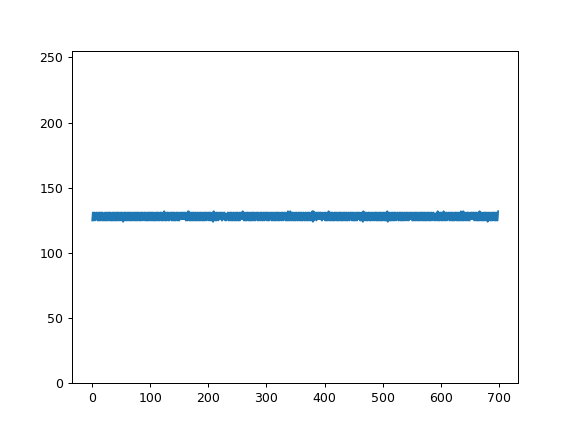

In [3]:
%matplotlib notebook
fig,ax = plt.subplots(1,1)

osc.write(':WAV:SOUR CHAN1')
time.sleep(0.01)
osc.write(':WAV:MODE NORM')
time.sleep(0.01)
#osc.write(':WAV:FORM BYTE')
#osc.write(':WAV:POIN 700')

osc.write(':WAV:DATA?')
wave1 = bytearray(osc.read(500))
wave2 = bytearray(osc.read(500))
wave = np.concatenate((wave1[11:],wave2[:(700-489)]))
fig.clf()
plt.ylim(0, 255)
plt.plot(wave)
fig.canvas.draw()

 

# Capture notes

There is a FTP server that can save to CSV files.
Note:
Set Display:Persist:None
Set Display:Waveform:Dots

8888 is for remote control.

See also:
https://www.eevblog.com/forum/testgear/micsig-to1104-(similar-to-rigol-1104z)/125/

## Read number of waveforms and wtite it to a file

<IPython.core.display.Javascript object>


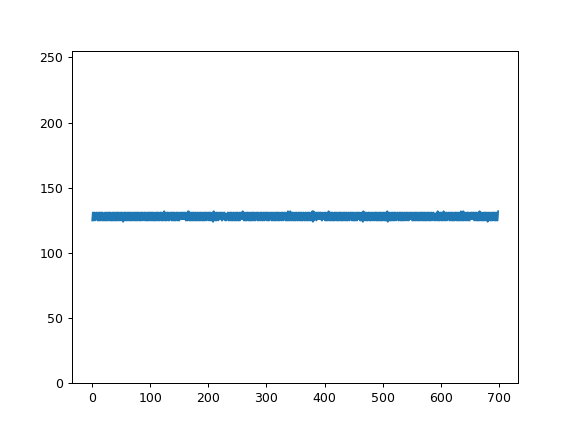

XINC: 5e-07
YINC: 0.0004


In [4]:
runs = 10

%matplotlib notebook
fig,ax = plt.subplots(1,1)

osc.write(':WAV:XINC?')
xinc = float(osc.read(100))
print 'XINC:', xinc
osc.write(':WAV:YINC?')
yinc = float(osc.read(100))
print 'YINC:', yinc

osc.write(':WAV:SOUR CHAN1')
osc.write(':WAV:MODE NORM')
osc.write(':WAV:FORM BYTE')
osc.write(':WAV:POIN 700')

with h5py.File('data.h5', 'w') as hf:
    hf.create_dataset('XINC', data=(xinc))
    hf.create_dataset('YINC', data=(yinc))
    #hf.create_dataset('YINC', bytearray(yinc))
    for n in range(runs):
        #osc.write(':RUN')
        # waiting for SINGLE trigger
        osc.write(':SING')
        osc.write(':TRIG:STAT?')
        while (osc.read(4) != 'STOP'):
            osc.write(':TRIG:STAT?')
        time.sleep(0.1)

        #osc.write(':STOP')
        osc.write(':WAV:DATA?')
        wave1 = bytearray(osc.read(500))
        wave2 = bytearray(osc.read(500))
        wave = np.concatenate((wave1[11:],wave2[:(700-489)]))
        #osc.write(':WAV:RES')
        hf.create_dataset(str(n), data=wave)
        fig.clf()
        plt.ylim(0, 255)
        plt.plot(wave)
        fig.canvas.draw()

 

## Read waveforms from the file

XINC: 5e-07    YINC: 0.0004
124 132 89647
124 132 89647
124 132 89647
124 132 89647
124 132 89647
124 132 89647
124 132 89647
124 132 89647
124 132 89647
124 132 89647


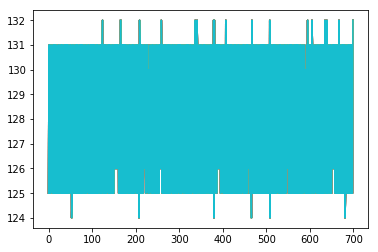

In [5]:
%matplotlib inline 

with h5py.File('data.h5','r') as hf:
    #print('List of arrays in this file: \n', hf.keys())
    print 'XINC:', np.array(hf.get('XINC')), '   YINC:', np.array(hf.get('YINC'))
    for n in range(10):
        data = hf.get(str(n))
        np_data = np.array(data)
        plt.plot(np_data)
        #print np_data
        maximum = 0
        minimum = 255
        suma = 0
        for i in range(700):
            if np_data[i] > maximum:
                maximum = np_data[i]
            if np_data[i] < minimum:
                minimum = np_data[i]
            suma = suma + np_data[i]
        print minimum, maximum, suma


## Capture waveforms and plot it

<IPython.core.display.Javascript object>


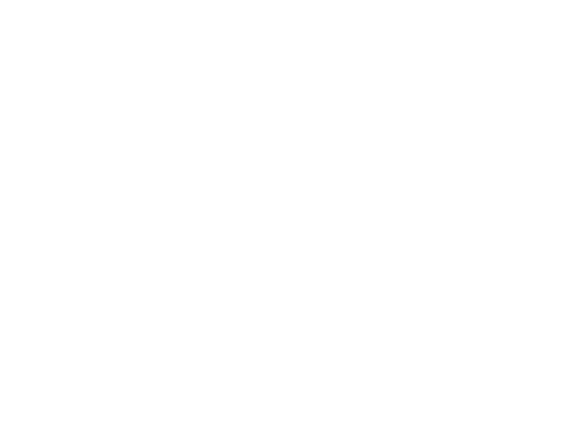

NameError: name 'pd' is not defined

In [7]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)

# looking for oscilloscope
devices =  getDeviceList()
# initiate oscilloscope
osc = UsbTmcDriver(devices[0])

df = pd.Series(0) # Create a new dataframe

for n in range(10):
    # waiting for SINGLE trigger
    osc.write(':SINGLE')
    osc.write(':TRIG:STAT?')
    while (osc.read(4) != 'STOP'):
        osc.write(':TRIG:STAT?')

    #osc.write(':STOP')
    osc.write(':WAV:SOUR CHAN1')
    osc.write(':WAV:MODE NORM')
    osc.write(':WAV:FORM BYTE')
    osc.write(':WAV:DATA?')

    #wave = map(float, osc.read(100).split(','))
    wave = bytearray(osc.read(1400))

    fig.clf()
    plt.ylim(0, 255)
    plt.plot(wave[10:])
    fig.canvas.draw()
    time.sleep(0.1)


XINC: 5e-07
YINC: 0.0004
XINC: 5e-07    YINC: 0.0004
124 132 89647
124 132 89647
124 132 89647
124 132 89647
124 132 89647
124 132 89647
124 132 89647
124 132 89647
124 132 89647
124 132 89647


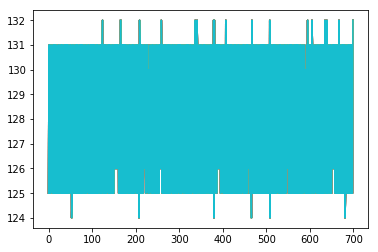

In [8]:
runs = 10

osc.write(':WAV:XINC?')
xinc = float(osc.read(100))
print 'XINC:', xinc
osc.write(':WAV:YINC?')
yinc = float(osc.read(100))
print 'YINC:', yinc

osc.write(':WAV:SOUR CHAN1')
osc.write(':WAV:MODE NORM')
osc.write(':WAV:FORM BYTE')
osc.write(':WAV:POIN 700')

with h5py.File('data.h5', 'w') as hf:
    hf.create_dataset('XINC', data=(xinc))
    hf.create_dataset('YINC', data=(yinc))
    #hf.create_dataset('YINC', bytearray(yinc))
    for n in range(runs):
        #osc.write(':RUN')
        # waiting for SINGLE trigger
        osc.write(':SING')
        osc.write(':TRIG:STAT?')
        while (osc.read(4) != 'STOP'):
            osc.write(':TRIG:STAT?')
        time.sleep(0.2)

        #osc.write(':STOP')
        osc.write(':WAV:DATA?')
        wave1 = bytearray(osc.read(500))
        wave2 = bytearray(osc.read(500))
        wave = np.concatenate((wave1[11:],wave2[:(700-489)]))
        #osc.write(':WAV:END')
        hf.create_dataset(str(n), data=wave)

%matplotlib inline 

with h5py.File('data.h5','r') as hf:
    #print('List of arrays in this file: \n', hf.keys())
    print 'XINC:', np.array(hf.get('XINC')), '   YINC:', np.array(hf.get('YINC'))
    for n in range(10):
        data = hf.get(str(n))
        np_data = np.array(data)
        plt.plot(np_data)
        #print np_data
        maximum = 0
        minimum = 255
        suma = 0
        for i in range(700):
            if np_data[i] > maximum:
                maximum = np_data[i]
            if np_data[i] < minimum:
                minimum = np_data[i]
            suma = suma + np_data[i]
        print minimum, maximum, suma


<IPython.core.display.Javascript object>


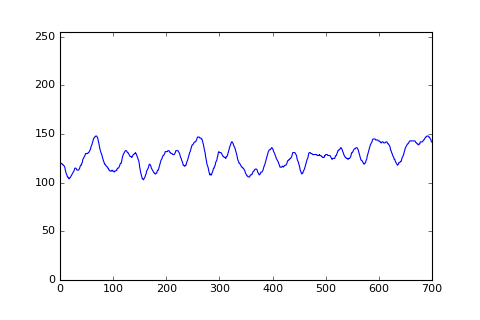

XINC: 2e-10
YINC: 0.0004


In [91]:
runs = 1

%matplotlib notebook
fig,ax = plt.subplots(1,1)

osc.write(':WAV:XINC?')
xinc = float(osc.read(100))
print 'XINC:', xinc
osc.write(':WAV:YINC?')
yinc = float(osc.read(100))
print 'YINC:', yinc

osc.write(':WAV:SOUR CHAN1')
osc.write(':WAV:MODE NORM')
osc.write(':WAV:FORM BYTE')
osc.write(':WAV:POIN 700')

with h5py.File('data.h5', 'w') as hf:
    hf.create_dataset('XINC', data=(xinc))
    hf.create_dataset('YINC', data=(yinc))
    #hf.create_dataset('YINC', bytearray(yinc))
    for n in range(runs):
        #osc.write(':RUN')
        # waiting for SINGLE trigger
        #osc.write(':SING')
        #osc.write(':TRIG:STAT?')
        #while (osc.read(4) != 'STOP'):
        #    osc.write(':TRIG:STAT?')
        #time.sleep(0.1)

        #osc.write(':STOP')
        osc.write(':WAV:DATA?')
        wave1 = bytearray(osc.read(500))
        wave2 = bytearray(osc.read(500))
        wave = np.concatenate((wave1[11:],wave2[:(700-489)]))
        #osc.write(':WAV:RES')
        hf.create_dataset(str(n), data=wave)
        fig.clf()
        plt.ylim(0, 255)
        plt.plot(wave)
        fig.canvas.draw()

 

## Readin buffer with stored records

In [217]:
with h5py.File('data.h5', 'w') as hf:
    osc.write(':FUNC:WREP:FEND?') # get number of last frame
    frames = int(osc.read(100))
    print 'FRAMES:', frames
    hf.create_dataset('FRAMES', data=(frames)) # write number of frames
    hf.create_dataset('XINC', data=(xinc)) # write axis parameters
    hf.create_dataset('YINC', data=(yinc))
    for n in range(1,frames+1):
        osc.write(':FUNC:WREP:FCUR ' + str(n)) # skip to n-th frame
        time.sleep(0.1)

        osc.write(':WAV:DATA?') # read data
        #time.sleep(0.4)
        wave1 = bytearray(osc.read(500))
        wave2 = bytearray(osc.read(500))
        wave = np.concatenate((wave1[11:],wave2[:(700-489)]))
        hf.create_dataset(str(n), data=wave)
    

FRAMES: 63


XINC: 2e-10    YINC: 0.0004    FRAMES: 63
103 145 87233
103 145 87233
103 145 87233
103 146 89092
103 145 87897
101 152 88042
100 142 87607
103 152 86780
103 150 87578
104 146 87954
107 153 88190
105 149 88007
97 151 87104
101 149 87967
101 148 85852
103 145 87901
107 152 89560
100 151 88111
103 145 86962
101 151 90102
109 147 88865
104 150 89023
104 148 90079
100 146 88091
109 148 89772
99 149 87950
105 149 90386
106 145 89144
102 148 87324
103 150 86909
98 152 88214
98 144 87709
105 146 88565
107 151 90289
103 147 88009
102 148 87115
104 150 88885
102 147 87891
102 148 86521
100 150 87720
102 147 87306
103 145 88096
103 145 85513
107 154 88847
104 150 88482
102 150 86685
107 148 90069
104 150 91686
100 150 86378
99 152 89075
109 149 90434
105 148 87319
107 150 90804
101 147 89014
104 146 87778
100 152 88572
104 151 90475
107 150 88019
104 148 86880
102 148 86379
101 144 85813
101 149 89638
101 151 89416


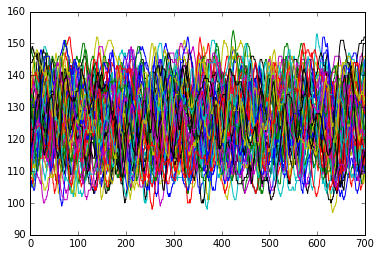

In [215]:
%matplotlib inline 

with h5py.File('data.h5','r') as hf:
    #print('List of arrays in this file: \n', hf.keys())
    print 'XINC:', np.array(hf.get('XINC')), '   YINC:', np.array(hf.get('YINC')), '   FRAMES:', np.array(hf.get('FRAMES'))
    frames = np.array(hf.get('FRAMES'))
    for n in range(1,frames+1):
        data = hf.get(str(n))
        np_data = np.array(data)
        plt.plot(np_data)
        #print np_data
        maximum = 0
        minimum = 255
        suma = 0
        for i in range(700):
            if np_data[i] > maximum:
                maximum = np_data[i]
            if np_data[i] < minimum:
                minimum = np_data[i]
            suma = suma + np_data[i]
        print minimum, maximum, suma

In [10]:
%matplotlib inline 

import matplotlib.pyplot as plt
import sys
import os
import time
import h5py
import numpy as np


with h5py.File('data2.h5','r') as hf:
    #print('List of arrays in this file: \n', hf.keys())
    print 'XINC:', np.array(hf.get('XINC')), '   YINC:', np.array(hf.get('YINC')), '   FRAMES:', np.array(hf.get('FRAMES'))
    frames = np.array(hf.get('FRAMES'))
    for n in range(1,frames+1):
        data = hf.get(str(n))
        np_data = np.array(data)
        plt.plot(np_data)
        #print np_data
        maximum = 0
        minimum = 255
        suma = 0
        for i in range(700):
            if np_data[i] > maximum:
                maximum = np_data[i]
            if np_data[i] < minimum:
                minimum = np_data[i]
            suma = suma + np_data[i]
        if n<10:
            print n,',', minimum,',', maximum,',', suma

IOError: Unable to open file (unable to open file: name = 'data2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)